# Bayesian black-box model-predictive control

An Expected Free Energy minimizing agent based on a nonlinear autoregressive model with exogenous input.

## System: NARX

Consider a system generating observations $y_k \in \mathbb{R}$ based on inputs $u_k \in \mathbb{R}$:

$$ y_k = \theta^{\top}\phi(u_k, x_k) + e_k \, ,$$

where $x_k \in \mathbb{R}^{D}$ is a vector of previous observations and $\theta$ are coefficients. The noise instances $e_k$ are assumed to be zero-mean Gaussian distributed with variance $\sigma^2$.

In [35]:
using Revise
using FFTW
using DSP
using ForwardDiff
using Optim
using RxInfer
using SpecialFunctions
using LinearAlgebra
using ProgressMeter
using Distributions
using Plots; default(grid=false, label="", linewidth=3, margin=20Plots.pt)

includet("../NARXAgents.jl"); using .NARXAgents
includet("../NARXsystem.jl"); using .NARXsystem

In [36]:
# Time
N = 100
fs = 20 # Hertz
Δt = 1/fs
tsteps = collect(range(0.0, step=Δt, length=N));

In [37]:
# Define system parameters
sys_mnoise_sd = 1e-2;
input_lims = (-1.,1.)

H = 3
# function sys_basis(x::AbstractVector) 
#     basis = [1.0]
#     for n in 1:length(x)
#         for d in 1:H
#             push!(basis, x[n].^d)
#         end
#     end
#     return basis
# end
# rbf(x, a=0.0, l=1.0) = exp(-(x-a)^2./l)
# sys_basis(x) = cat([1; [rbf(x, a=a) for a in range(-1, stop=1, length=H)]]...,dims=1)
sys_basis(x) = cat([1.0; [x.^d for d in 1:H]]...,dims=1)

M_in = 2
M_out = 2
M = size(sys_basis(zeros(M_out + 1 + M_in)),1);
# sys_coefficients = [0.0; -cos.((1:M-1.)./(π))./2]

df = digitalfilter(Lowpass(1.2; fs=fs), Butterworth(maximum([M_in, M_out])))
sys_coefficients = [0.0; sys_basis([coefb(df)[2:M_out+1]; coefa(df)[1:M_in+1]])[2:end]]

16-element Vector{Float64}:
  0.0
  0.05571953223427204
  0.02785976611713602
  1.0
 -1.475480443592646
  0.5869195080611902
  0.003104666272406081
  0.0007761665681015203
  1.0
  2.1770425394243516
  0.3444745089427895
  0.00017299055244198786
  2.1623819055248483e-5
  1.0
 -3.2121836917899027
  0.20217880932832208

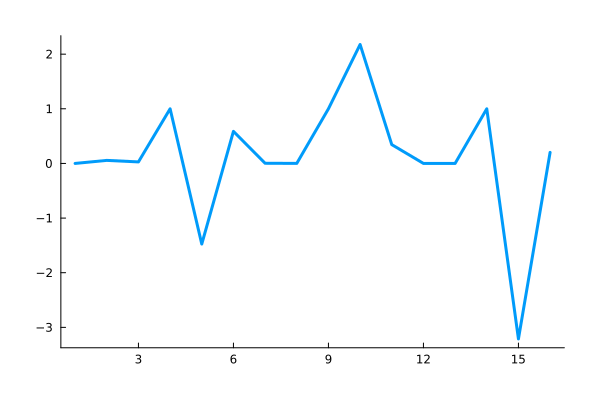

In [38]:
plot(sys_coefficients)

In [39]:
# Specify prior distributions
pτ0 = GammaShapeRate(1e0, 1e0)
pθ0 = MvNormalMeanCovariance(zeros(M), 1e2diagm(ones(M)))
goal = NormalMeanVariance(0.5, 10.0)

NormalMeanVariance{Float64}(μ=0.5, v=10.0)

## Parameter estimation: random

In [40]:
# Inputs
controls = clamp!(randn(N), input_lims...)

100-element Vector{Float64}:
  0.024081150339286456
 -0.7928095343378402
  0.5672682638149829
 -0.0317670031718346
  0.5566576458869822
 -1.0
  1.0
 -0.12992663942593513
 -0.27692194750686705
  0.7576344529235238
  ⋮
  0.46941686606536814
  1.0
  1.0
 -1.0
  0.7035283724598368
 -0.28635329185515596
  0.6185989204055437
 -1.0
 -0.7171542092467852

In [41]:
# Outputs
system = NARXsys(sys_coefficients, sys_basis, sys_mnoise_sd, order_outputs=M_out, order_inputs=M_in, input_lims=input_lims)

outputs = zeros(N)
inputs = zeros(N)
for k in 1:N
    NARXsystem.update!(system, controls[k])
    outputs[k] = system.observation
    inputs[k] = system.input_buffer[1]
end

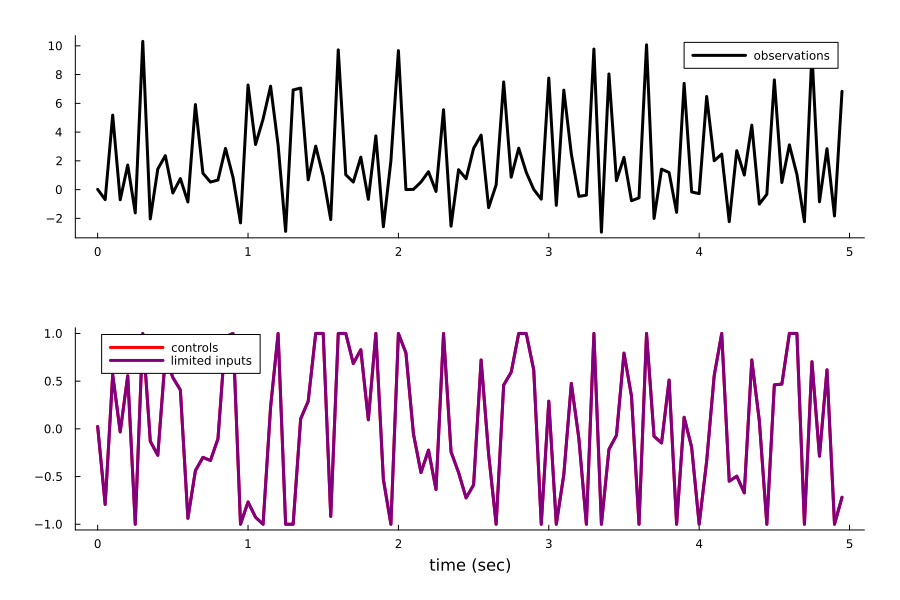

In [42]:
p101 = plot(tsteps, outputs, color="black", label="observations")
p102 = plot(tsteps, controls, color="red", label="controls", xlabel="time (sec)")
plot!(tsteps, inputs, color="purple", label="limited inputs", xlabel="time (sec)")
plot(p101, p102, layout=grid(2,1), size=(900,600))

In [43]:
py_rnd = []
qθ_rnd = [pθ0]
qτ_rnd = [pτ0]
FE_rnd = zeros(10,N)

agent = NARXAgent(pθ0, pτ0, 
                  goal_prior=goal, 
                  delay_inp=M_in, 
                  delay_out=M_out, 
                  pol_degree=H)

T = 10
inputs_ = [inputs; zeros(T)]

@showprogress for k in 1:N
    
    # Make predictions
    push!(py_rnd, predictions(agent, inputs_[k:k+T], time_horizon=T))
    
    # Update beliefs
    NARXAgents.update!(agent, outputs[k], inputs[k])
    push!(qθ_rnd, agent.qθ)
    push!(qτ_rnd, agent.qτ)
    
    # Evaluate
    FE_rnd[:,k] = agent.free_energy
end

Progress:  75%|██████████████████████████████▊          |  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


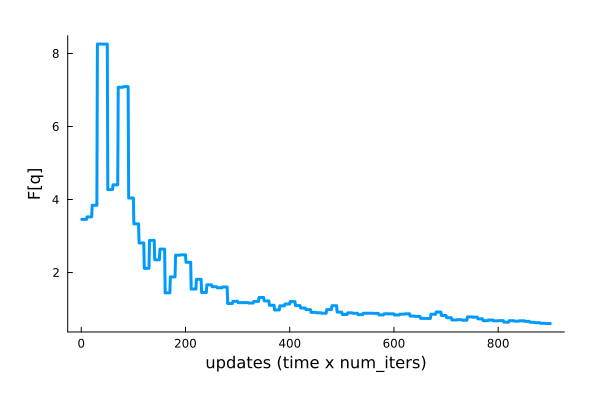

In [44]:
plot(reshape(FE_rnd[:,1:(N-T)], (10*(N-T),)), xlabel="updates (time x num_iters)", ylabel="F[q]")

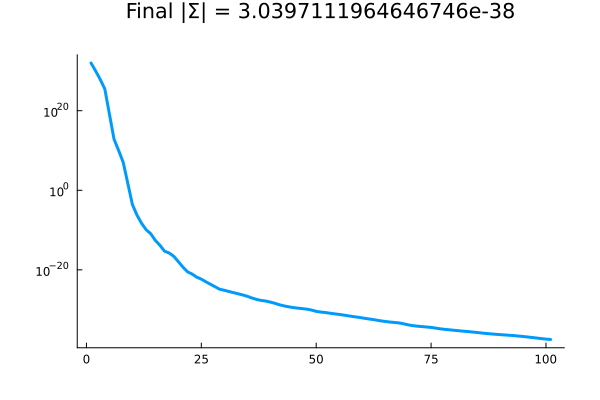

In [45]:
dSθ_rnd = det.(cov.(qθ_rnd))
final_dSθ_rnd = dSθ_rnd[end]
plot(dSθ_rnd, title="Final |Σ| = $final_dSθ_rnd", yscale=:log10)

## Parameter estimation: sinusoid control

In [46]:
# Inputs
Ω  = rand(5)*10
controls = mean([sin.(ω.*tsteps) for ω in Ω]);

In [47]:
# Outputs
system = NARXsys(sys_coefficients, sys_basis, sys_mnoise_sd, order_outputs=M_out, order_inputs=M_in, input_lims=input_lims)

outputs = zeros(N)
inputs = zeros(N)
for k in 1:N
    NARXsystem.update!(system, controls[k])
    outputs[k] = system.observation
    inputs[k] = system.input_buffer[1]
end

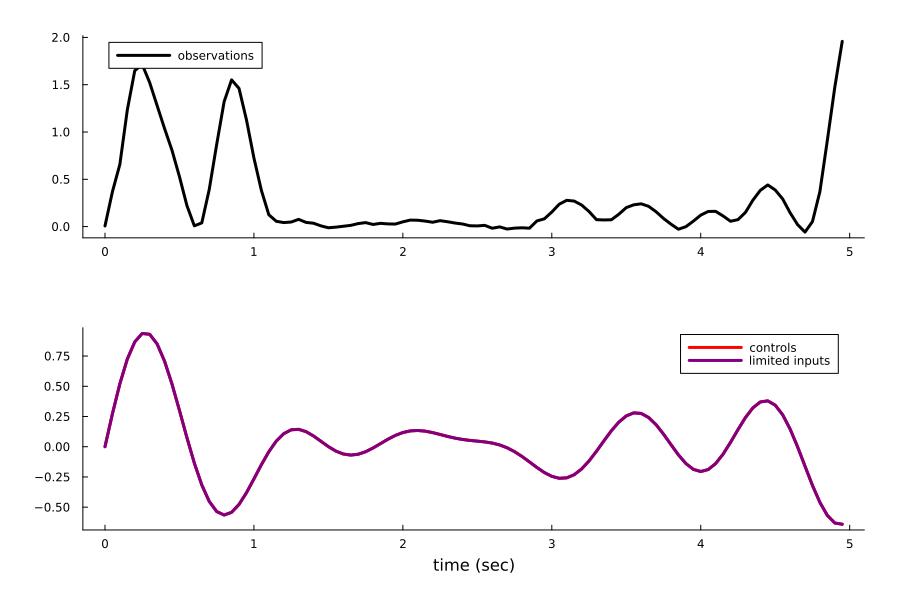

In [48]:
p101 = plot(tsteps, outputs, color="black", label="observations")
p102 = plot(tsteps, controls, color="red", label="controls", xlabel="time (sec)")
plot!(tsteps, inputs, color="purple", label="limited inputs", xlabel="time (sec)")
plot(p101, p102, layout=grid(2,1), size=(900,600))

In [49]:
py_sin = []
qθ_sin = [pθ0]
qτ_sin = [pτ0]
FE_sin = zeros(10,N)

agent = NARXAgent(pθ0, pτ0, 
                  goal_prior=goal, 
                  delay_inp=M_in, 
                  delay_out=M_out, 
                  pol_degree=H)

T = 10
inputs_ = [inputs; zeros(T)]

@showprogress for k in 1:N
    
    # Make predictions
    push!(py_sin, predictions(agent, inputs_[k:k+T], time_horizon=T))
    
    # Update beliefs
    NARXAgents.update!(agent, outputs[k], inputs[k])
    push!(qθ_sin, agent.qθ)
    push!(qτ_sin, agent.qτ)
    
    # Evaluate
    FE_sin[:,k] = agent.free_energy
end

Progress:  97%|███████████████████████████████████████▊ |  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


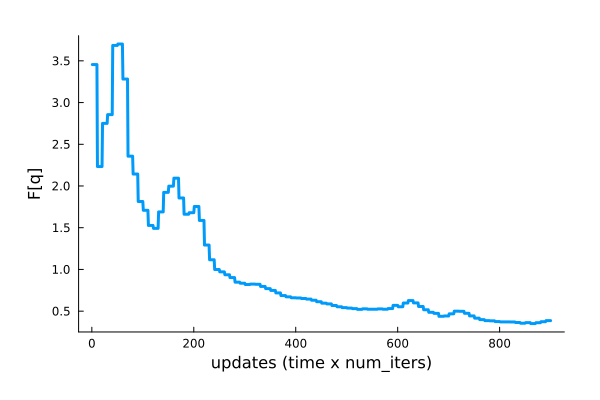

In [50]:
plot(reshape(FE_sin[:,1:(N-T)], (10*(N-T),)), xlabel="updates (time x num_iters)", ylabel="F[q]")

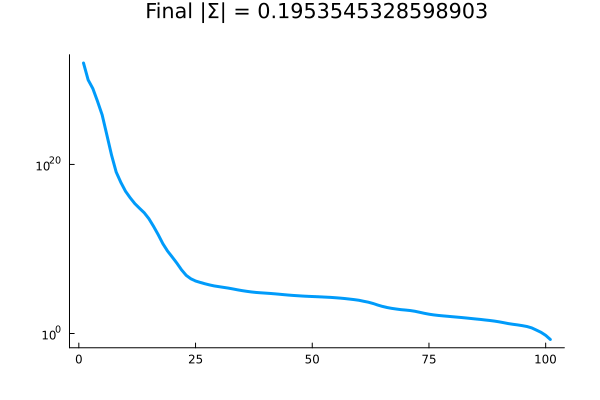

In [51]:
dSθ_sin = det.(cov.(qθ_sin))
final_dSθ_sin = dSθ_sin[end]
plot(dSθ_sin, title="Final |Σ| = $final_dSθ_sin", yscale=:log10)

In [52]:
# pw = []
# for m in 1:M
#     pwm = plot(ylims=(-1.,1.))
    
#     hline!([sys_coefficients[m]], color="black", label="true")
#     plot!(mθ[m,:], ribbon=sqrt.(vθ[m,:]), color="purple", label="belief", ylabel="θ_$m")
    
#     push!(pw,pwm)
# end
# plot(pw..., layout=(M,1), size=(900,M*300))

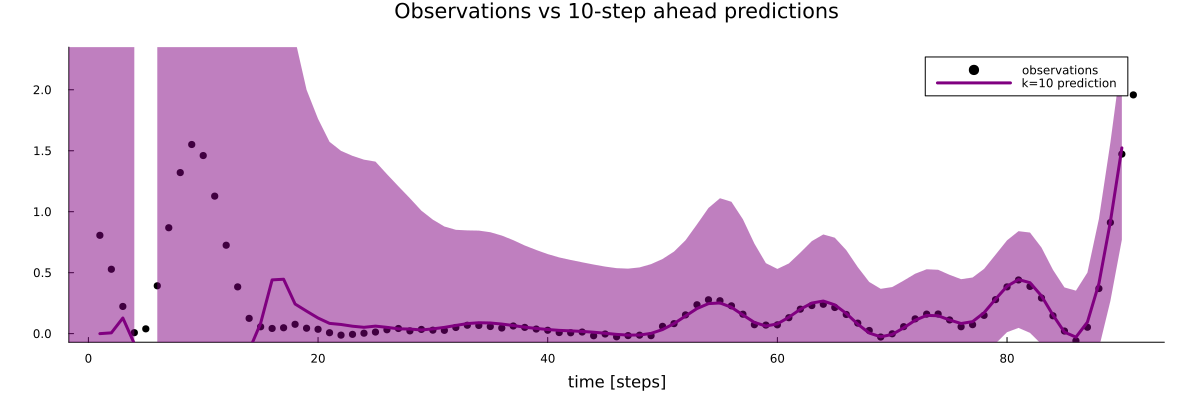

In [53]:
limsb = [minimum(outputs)*1.2, maximum(outputs)*1.2]
K = 10

p1 = plot(xlabel="time [steps]", title="Observations vs $K-step ahead predictions", ylims=limsb, size=(1200,400))
scatter!(outputs[K:end], color="black", label="observations")
plot!([py_sin[k][1][K] for k in 1:(N-T)], ribbon=[py_sin[k][2][K] for k in 1:(N-T)], color="purple", label="k=$K prediction")

## Parameter estimation: EFE

In [54]:
T = 10

# Set control properties
control_prior = 0.0
num_iters = 10
tlimit = 10

10

In [74]:
# Start system
system = NARXsys(sys_coefficients, 
                 sys_basis,
                 sys_mnoise_sd, 
                 order_outputs=M_out, 
                 order_inputs=M_in)

goals = [NormalMeanVariance(mean(goal), 1e3) for t in 1:T]
gvars = 10 .^range(3, stop=-1, length=N)

# Start agent
agent = NARXAgent(pθ0, pτ0, 
                  goal_prior=goals, 
                  delay_inp=M_in, 
                  delay_out=M_out, 
                  pol_degree=H,
                  thorizon=T)

# Preallocate
y_EFE = zeros(N)
u_EFE = zeros(N+T)
pτ_EFE = [pτ0]
pθ_EFE = [pθ0]
py_EFE = []
FE_EFE = zeros(num_iters, N)

@showprogress for k in 1:N
    
    # Act upon environment
    NARXsystem.update!(system, u_EFE[k])
    y_EFE[k] = system.observation
    
    # Update parameter beliefs
    NARXAgents.update!(agent, y_EFE[k], u_EFE[k])
    
    FE_EFE[:,k] = agent.free_energy
    push!(pθ_EFE, agent.qθ)
    push!(pτ_EFE, agent.qτ)
    
    # Move goal closer
    goal_k = NormalMeanVariance(mean(goal), gvars[k])
    update_goals!(goals, goal_k)
    agent.goals = goals
    
    # Optimal control
    policy = minimizeEFE(agent, goals, time_limit=tlimit, control_lims=input_lims)
    u_EFE[k+1:k+T] = policy
    
    # Store future predictions
    push!(py_EFE, predictions(agent, policy, time_horizon=T))
    
end

Progress:   2%|▉                                        |  ETA: 0:00:17

Progress:  12%|████▉                                    |  ETA: 0:01:15

Progress:  13%|█████▍                                   |  ETA: 0:01:16

Progress:  14%|█████▊                                   |  ETA: 0:01:12

Progress:  15%|██████▏                                  |  ETA: 0:01:08

Progress:  16%|██████▌                                  |  ETA: 0:01:08

Progress:  17%|███████                                  |  ETA: 0:01:06

Progress:  18%|███████▍                                 |  ETA: 0:01:02

Progress:  19%|███████▊                                 |  ETA: 0:01:00

Progress:  20%|████████▎                                |  ETA: 0:00:57

Progress:  21%|████████▋                                |  ETA: 0:00:55

Progress:  22%|█████████                                |  ETA: 0:00:54

Progress:  23%|█████████▍                               |  ETA: 0:00:51

Progress:  24%|█████████▉                               |  ETA: 0:00:52

Progress:  25%|██████████▎                              |  ETA: 0:00:50

Progress:  26%|██████████▋                              |  ETA: 0:00:50

Progress:  27%|███████████▏                             |  ETA: 0:00:49

Progress:  28%|███████████▌                             |  ETA: 0:00:47

Progress:  29%|███████████▉                             |  ETA: 0:00:48

Progress:  30%|████████████▎                            |  ETA: 0:00:47

Progress:  31%|████████████▊                            |  ETA: 0:00:45

Progress:  32%|█████████████▏                           |  ETA: 0:00:43

Progress:  33%|█████████████▌                           |  ETA: 0:00:42

Progress:  35%|██████████████▍                          |  ETA: 0:00:39

Progress:  38%|███████████████▋                         |  ETA: 0:00:34

Progress:  41%|████████████████▊                        |  ETA: 0:00:30

Progress:  44%|██████████████████                       |  ETA: 0:00:30

Progress:  46%|██████████████████▉                      |  ETA: 0:00:40

Progress:  47%|███████████████████▎                     |  ETA: 0:00:44

Progress:  48%|███████████████████▋                     |  ETA: 0:00:44

Progress:  49%|████████████████████▏                    |  ETA: 0:00:42

Progress:  50%|████████████████████▌                    |  ETA: 0:00:42

Progress:  51%|████████████████████▉                    |  ETA: 0:00:41

Progress:  52%|█████████████████████▍                   |  ETA: 0:00:39

Progress:  56%|███████████████████████                  |  ETA: 0:00:33

Progress:  59%|████████████████████████▎                |  ETA: 0:00:30

Progress:  60%|████████████████████████▋                |  ETA: 0:00:29

Progress:  61%|█████████████████████████                |  ETA: 0:00:28

Progress:  63%|█████████████████████████▉               |  ETA: 0:00:26

Progress:  66%|███████████████████████████              |  ETA: 0:00:23

Progress:  69%|████████████████████████████▎            |  ETA: 0:00:20

Progress:  72%|█████████████████████████████▌           |  ETA: 0:00:17

Progress:  74%|██████████████████████████████▍          |  ETA: 0:00:16

Progress:  76%|███████████████████████████████▏         |  ETA: 0:00:14

Progress:  78%|████████████████████████████████         |  ETA: 0:00:13

Progress:  80%|████████████████████████████████▊        |  ETA: 0:00:11

Progress:  83%|██████████████████████████████████       |  ETA: 0:00:09

Progress:  85%|██████████████████████████████████▉      |  ETA: 0:00:08

Progress:  87%|███████████████████████████████████▋     |  ETA: 0:00:07

Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:06

Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:04

Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:03

Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:02

Progress:  97%|███████████████████████████████████████▊ |  ETA: 0:00:01

Progress:  99%|████████████████████████████████████████▋|  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


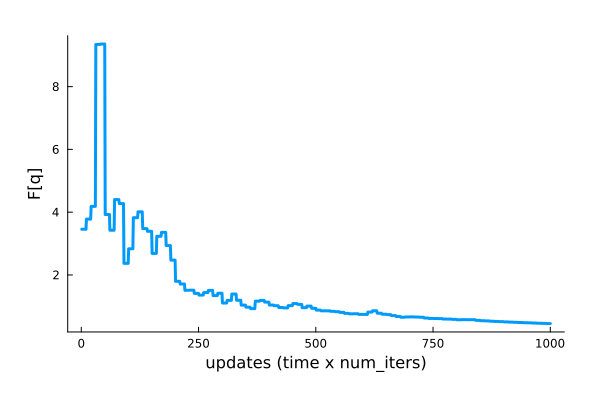

In [75]:
plot(FE_EFE[:], xlabel="updates (time x num_iters)", ylabel="F[q]")

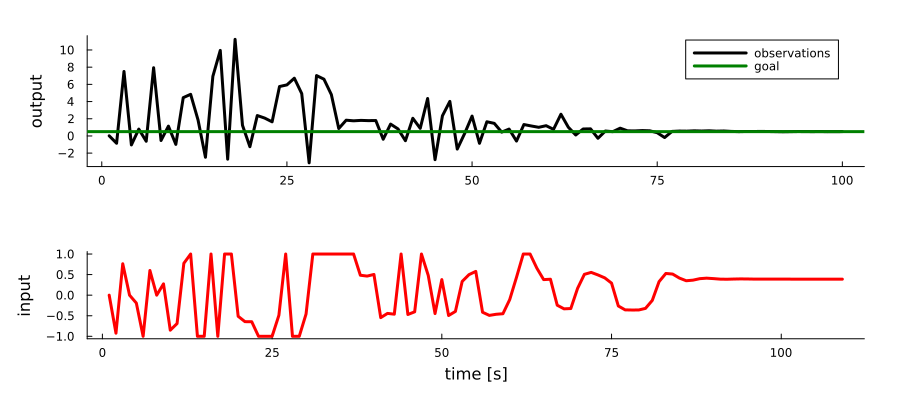

In [76]:
p1 = plot(y_EFE, color="black", label="observations", ylabel="output")
hline!([mean(goal)], color="green", label="goal")
# vline!([T], color="purple", linestyle=:dash, label="cut")
p4 = plot(u_EFE[1:end-1], color="red", ylabel="input", xlabel="time [s]")

plot(p1,p4, layout=grid(2,1, heights=[.6, .4]), size=(900,400))

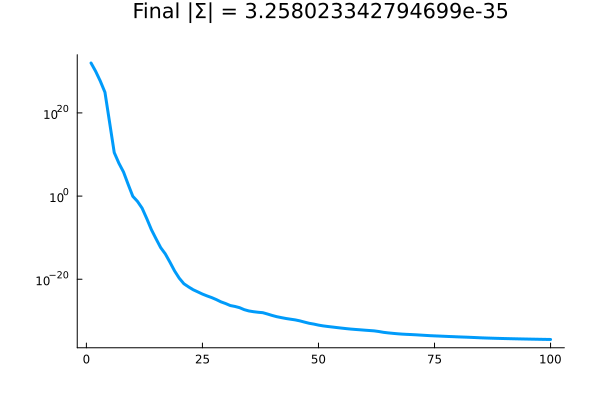

In [77]:
dSθ_EFE = [det(cov(pθ_EFE[k])) for k in 1:N]
final_dSθ_EFE = dSθ_EFE[end]
plot(dSθ_EFE, title="Final |Σ| = $final_dSθ_EFE", yscale=:log10)

In [78]:
limsb = [minimum(y_EFE)*1.5, maximum(y_EFE)*1.5]

window = 20

anim = @animate for k in 2:(N-T-1)
    
    if k <= window
        plot(tsteps[1:k], y_EFE[1:k], color="blue", xlims=(tsteps[1], tsteps[window+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_EFE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], py_EFE[k][1], ribbon=py_EFE[k][2], label="predicted future", color="orange", legend=:topleft)
        hline!([mean(goals[1])], color="green")
    else
        plot(tsteps[k-window:k], y_EFE[k-window:k], color="blue", xlims=(tsteps[k-window], tsteps[k+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_EFE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], py_EFE[k][1], ribbon=py_EFE[k][2], label="prediction", color="orange", legend=:topleft)
        hline!([mean(goals[1])], color="green")
    end
    
end
# gif(anim, "figures/NARX-EFE-verification-planning.gif", fps=24)

Animation("/tmp/jl_8LVYyP", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000079.png", "000080.png", "000081.png", "000082.png", "000083.png", "000084.png", "000085.png", "000086.png", "000087.png", "000088.png"])

## Parameter estimation: MSE

In [79]:
# Start system
system = NARXsys(sys_coefficients, 
                 sys_basis,
                 sys_mnoise_sd, 
                 order_outputs=M_out, 
                 order_inputs=M_in,
                 input_lims=input_lims)

# Start agent
agent = NARXAgent(pθ0, pτ0, 
                  goal_prior=goals, 
                  delay_inp=M_in, 
                  delay_out=M_out, 
                  pol_degree=H,
                  thorizon=T)

# Preallocate
y_MSE = zeros(N)
u_MSE = zeros(N+T)
pτ_MSE = [pτ0]
pθ_MSE = [pθ0]
py_MSE = []
FE_MSE = zeros(num_iters, N)

@showprogress for k in 1:N
    
    # Act upon environment
    NARXsystem.update!(system, u_MSE[k])
    y_MSE[k] = system.observation
    
    # Update parameter beliefs
    NARXAgents.update!(agent, y_MSE[k], u_MSE[k])
    
    FE_MSE[:,k] = agent.free_energy
    push!(pθ_MSE, agent.qθ)
    push!(pτ_MSE, agent.qτ)
    
    # Optimal control
    policy = minimizeMSE(agent, goals, time_limit=tlimit, control_lims=input_lims)
    u_MSE[k+1] = policy[1]
    
    # Store future predictions
    push!(py_MSE, predictions(agent, policy, time_horizon=T))
    
end

Progress:   8%|███▎                                     |  ETA: 0:00:10

Progress:  12%|████▉                                    |  ETA: 0:00:07

Progress:  17%|███████                                  |  ETA: 0:00:05

Progress:  22%|█████████                                |  ETA: 0:00:04

Progress:  27%|███████████▏                             |  ETA: 0:00:04

Progress:  32%|█████████████▏                           |  ETA: 0:00:03

Progress:  38%|███████████████▋                         |  ETA: 0:00:03

Progress:  43%|█████████████████▋                       |  ETA: 0:00:02

Progress:  48%|███████████████████▋                     |  ETA: 0:00:02

Progress:  53%|█████████████████████▊                   |  ETA: 0:00:02

Progress:  58%|███████████████████████▊                 |  ETA: 0:00:01

Progress:  63%|█████████████████████████▉               |  ETA: 0:00:01

Progress:  69%|████████████████████████████▎            |  ETA: 0:00:01

Progress:  74%|██████████████████████████████▍          |  ETA: 0:00:01

Progress:  79%|████████████████████████████████▍        |  ETA: 0:00:01

Progress:  84%|██████████████████████████████████▌      |  ETA: 0:00:00

Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:00

Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

Progress:  99%|████████████████████████████████████████▋|  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


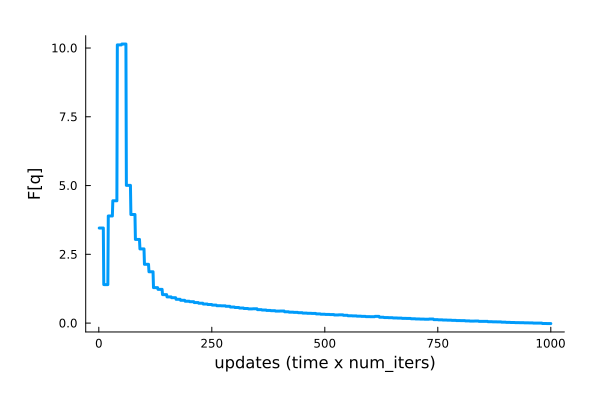

In [80]:
plot(FE_MSE[:], xlabel="updates (time x num_iters)", ylabel="F[q]")

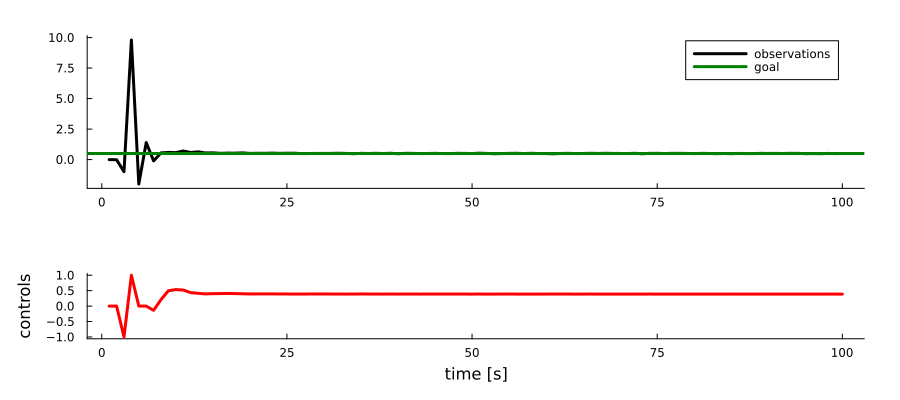

In [81]:
p1 = plot(y_MSE, color="black", label="observations")
hline!([mean(goal)], color="green", label="goal")
p4 = plot(u_MSE[1:end-T], color="red", ylabel="controls", xlabel="time [s]")

plot(p1,p4, layout=grid(2,1, heights=[.7, .3]), size=(900,400))

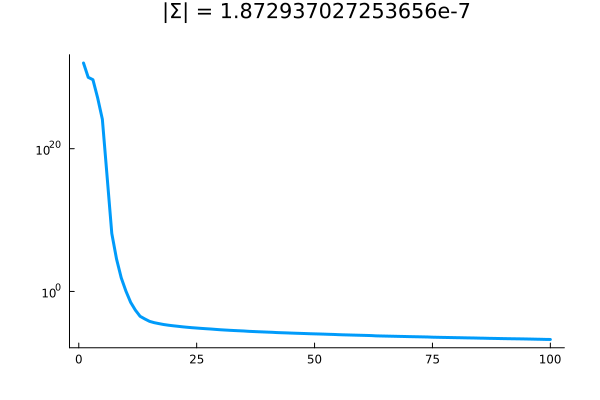

In [82]:
dSθ_MSE = [det(cov(pθ_MSE[k])) for k in 1:N]
final_dSθ_MSE = dSθ_MSE[end]
plot(dSθ_MSE, title="|Σ| = $final_dSθ_MSE", yscale=:log10)

In [83]:
limsb = [minimum(y_MSE)*1.5, maximum(y_MSE)*1.5]
window = 20

anim = @animate for k in 2:(N-T-1)
    
    if k <= window
        plot(tsteps[1:k], y_MSE[1:k], color="blue", xlims=(tsteps[1], tsteps[window+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_MSE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], py_MSE[k][1], ribbon=py_MSE[k][2], label="predicted future", color="orange", legend=:topleft)
        hline!([mean(goal)], color="green")
    else
        plot(tsteps[k-window:k], y_MSE[k-window:k], color="blue", xlims=(tsteps[k-window], tsteps[k+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_MSE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], py_MSE[k][1], ribbon=py_MSE[k][2], label="prediction", color="orange", legend=:topleft)
        hline!([mean(goal)], color="green")
    end
    
end
# gif(anim, "figures/NARX-MSE-verification-planning.gif", fps=24)

Animation("/tmp/jl_bd4utP", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000079.png", "000080.png", "000081.png", "000082.png", "000083.png", "000084.png", "000085.png", "000086.png", "000087.png", "000088.png"])

### Comparison

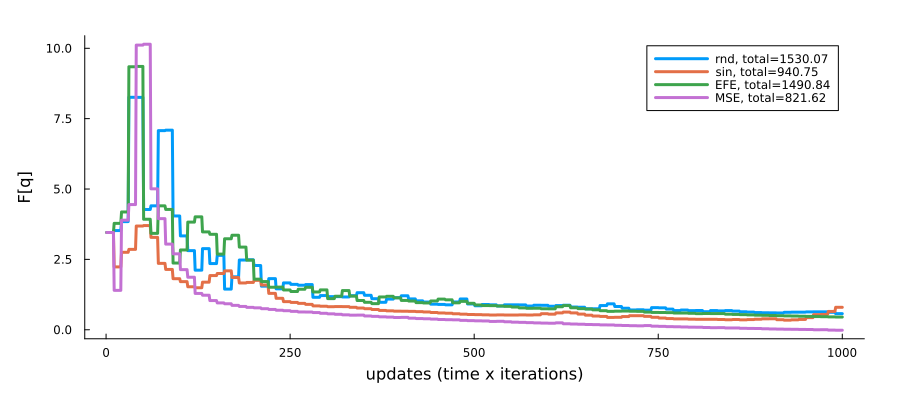

In [84]:
sF_rnd = round(sum(FE_rnd[:]), digits=2)
sF_sin = round(sum(FE_sin[:]), digits=2)
sF_MSE = round(sum(FE_MSE[:]), digits=2)
sF_EFE = round(sum(FE_EFE[:]), digits=2)

plot(xlabel="updates (time x iterations)", ylabel="F[q]", size=(900,400))
plot!(FE_rnd[:], label="rnd, total=$sF_rnd")
plot!(FE_sin[:], label="sin, total=$sF_sin")
plot!(FE_EFE[:], label="EFE, total=$sF_EFE")
plot!(FE_MSE[:], label="MSE, total=$sF_MSE")


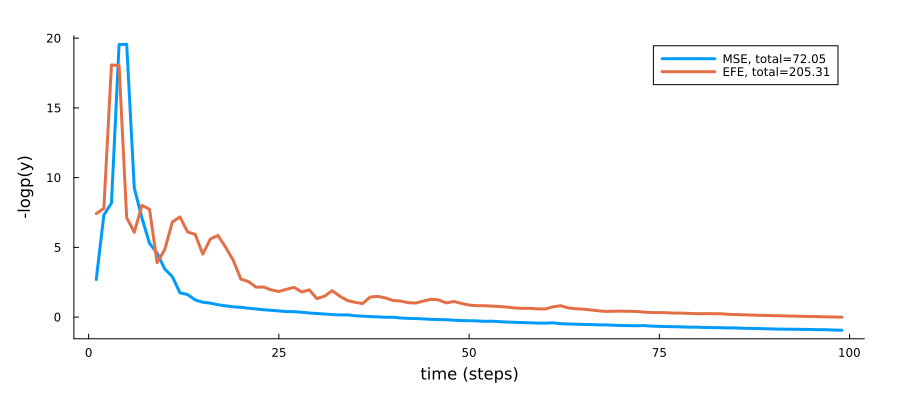

In [85]:
evidence_MSE = [-logpdf(Normal(py_MSE[k][1][1], py_MSE[k][2][1]), y_MSE[k+1]) for k in 1:(N-1)]
evidence_EFE = [-logpdf(Normal(py_EFE[k][1][1], py_EFE[k][2][1]), y_EFE[k+1]) for k in 1:(N-1)]

total_evidence_MSE = round(sum(evidence_MSE), digits=2)
total_evidence_EFE = round(sum(evidence_EFE), digits=2)

plot(xlabel="time (steps)", ylabel="-logp(y)", size=(900,400))
plot!(evidence_MSE, label="MSE, total=$total_evidence_MSE")
plot!(evidence_EFE, label="EFE, total=$total_evidence_EFE")

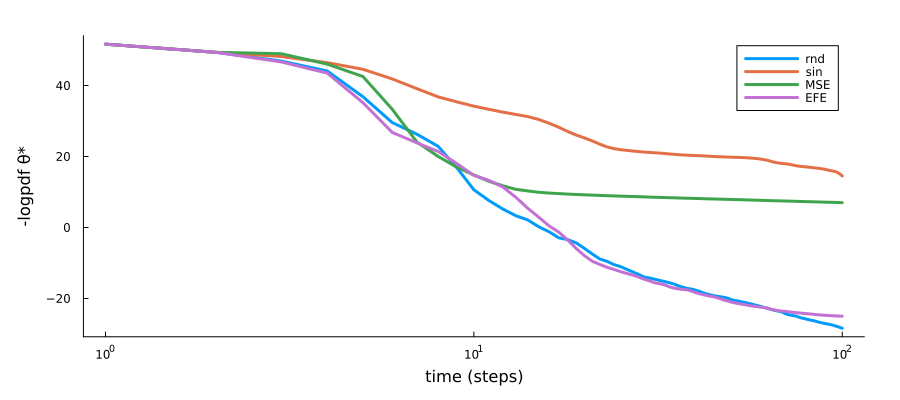

In [86]:
idθ_rnd = [-logpdf(qθ_rnd[k], sys_coefficients) for k in 1:N]
idθ_sin = [-logpdf(qθ_sin[k], sys_coefficients) for k in 1:N]
idθ_MSE = [-logpdf(pθ_MSE[k], sys_coefficients) for k in 1:N]
idθ_EFE = [-logpdf(pθ_EFE[k], sys_coefficients) for k in 1:N]

plot(xlabel="time (steps)", xscale=:log10, ylabel="-logpdf θ*", size=(900,400))
plot!(idθ_rnd, label="rnd")
plot!(idθ_sin, label="sin")
plot!(idθ_MSE, label="MSE")
plot!(idθ_EFE, label="EFE")

In [87]:
savefig("figures/nllθ-comparison.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/notebooks/figures/nllθ-comparison.png"